#Peak Prediction - Kyoto



In [338]:
#import dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [339]:
cd drive/MyDrive/peak_prediction/

[Errno 2] No such file or directory: 'drive/MyDrive/peak_prediction/'
/content/drive/MyDrive/peak_prediction


In [340]:
ls

catboost_info/
daily_temperatures_impute_missing.csv
imputed_data.csv
japan.csv
kyoto.csv
liestal.csv
merged_kyoto.csv
merged_kyoto.gsheet
merged_kyoto_off.csv
merged_liestal.csv
merged_liestal.gsheet
merged_liestal_off.csv
merged_vancouver.csv
merged_vancouver.gsheet
merged_vancouver_off.csv
merged_washington_1.csv
merged_washington_co2_test.csv
merged_washington_co2_test_excel.csv
merged_washington_co2_test.gsheet
merged_washington.csv
merged_washington.gsheet
merged_washington_off.csv
merged_washington_test.csv
merged_washington_test_excel.csv
merged_washington_test.gsheet
meteoswiss.csv
README.md
south_korea.csv
USA-NPN_individual_phenometrics_data.csv
USA-NPN_individual_phenometrics_datafield_descriptions.csv
USA-NPN_status_intensity_datafield_descriptions.csv
USA-NPN_status_intensity_observations_data.csv
vancouver.csv
washingtondc.csv


In [341]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE


from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import LabelEncoder
import scipy.integrate as integrate
import xgboost as xgb
from xgboost import plot_tree
!pip install catboost
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor


df = pd.read_csv("merged_kyoto_off.csv")
YEARS = df.year
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,lat,long,year,bloom_date,bloom_doy,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years,location,month,season,tmax_avg,tmax_max,tmin_avg,tmin_min,gdd_avg,prcp_avg
0,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,0,Winter,12.596774,20.2,2.390323,-2.4,7.493548,31.483871
1,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,1,Winter,9.277419,18.4,-0.141935,-4.8,4.567742,13.064516
2,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,2,Winter,11.889655,19.7,0.220690,-2.9,6.055172,9.344828
3,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,3,Spring,14.803226,24.1,3.922581,-2.2,9.362903,22.806452
4,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,4,Spring,18.213333,25.6,7.423333,-1.0,12.818333,49.600000


# 1. EDA

In [342]:
print(df.columns)
print()
min_date, max_date = df.bloom_doy.min(), df.bloom_doy.max()
print(f'Min bloom date = {min_date} days')
print(f'Max bloom date = {max_date} days')

"""1. Create hashmap: (bloom date class -> bloom date raw)"""
hm_bloom_date = {}
for idx, date in enumerate(range(min_date, max_date, 4)):
    hm_bloom_date[idx] = [date, date+3]
    print(hm_bloom_date[idx])

print(f"\tExample: class 0 is in range {hm_bloom_date[0]} days from Jan 1.")

df.head()

Index(['lat', 'long', 'year', 'bloom_date', 'bloom_doy', 'cat_bloom_doy',
       'cat_bloom_doy_1_year', 'cat_bloom_doy_2_years', 'location', 'month',
       'season', 'tmax_avg', 'tmax_max', 'tmin_avg', 'tmin_min', 'gdd_avg',
       'prcp_avg'],
      dtype='object')

Min bloom date = 85 days
Max bloom date = 110 days
[85, 88]
[89, 92]
[93, 96]
[97, 100]
[101, 104]
[105, 108]
[109, 112]
	Example: class 0 is in range [85, 88] days from Jan 1.


,lat,long,year,bloom_date,bloom_doy,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years,location,month,season,tmax_avg,tmax_max,tmin_avg,tmin_min,gdd_avg,prcp_avg
0,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,0,Winter,12.596774,20.2,2.390323,-2.4,7.493548,31.483871
1,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,1,Winter,9.277419,18.4,-0.141935,-4.8,4.567742,13.064516
2,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,2,Winter,11.889655,19.7,0.220690,-2.9,6.055172,9.344828
3,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,3,Spring,14.803226,24.1,3.922581,-2.2,9.362903,22.806452
4,35.011983,135.676114,1960,1960-04-04,95,2,NaN,NaN,kyoto,4,Spring,18.213333,25.6,7.423333,-1.0,12.818333,49.600000


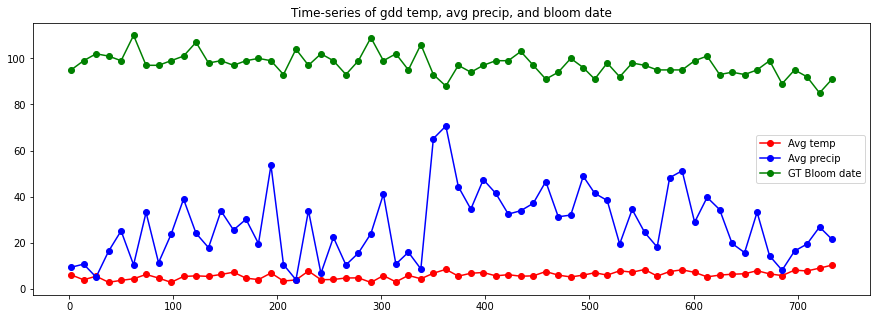

In [343]:
MONTH = 2
plt.figure(figsize=(15,5))
plt.title('Time-series of gdd temp, avg precip, and bloom date')
plt.plot(df[df.month == MONTH].gdd_avg, '-o', color='red', label='Avg temp')
plt.plot(df[df.month == MONTH].prcp_avg, '-o', color='blue', label='Avg precip')
plt.plot(df[df.month == MONTH].bloom_doy, '-o', color='green', label='GT Bloom date')
plt.legend()

# 2a. Split input & labels
## PLUS: reformat label according to prediction range

In [344]:
def split_XY(df, input_features, output_features):
    """Preprocess input data"""
    X = df[input_features]
    if 'cat_bloom_doy_last_year' in X:
        X = X.astype({'cat_bloom_doy_last_year': int}, errors = 'ignore')
        
    if 'cat_bloom_doy_last_2_years' in X:
        X = X.astype({'cat_bloom_doy_last_2_years': int}, errors = 'ignore')
        

    """Preprocess labels"""
    Y = df[output_features]

    return X, Y

# ??????
def remove_first_two_years(df, YEARS):
    """Start with years >= year_min + 2 because we shifted cat_bloom_doy column by 2"""
    df = df[df.year >= YEARS.min() + 2]
    try: df = df.dropna().reset_index()
    except: pass
    print(df.year.min())

    return df

"""
    Reformat the label to fit the prediction range (in years)
    E.g: shift(-5) if aims to predict 5 years ahead
"""
def reformat_labels(df, label_name, prediction_range):
    df[label_name] = df[label_name].shift(-12 * prediction_range)
    df = df.dropna().reset_index()
    return df

#Select prediction date here


In [345]:
"""Split input & labels"""
input_features = ['month', 'tmax_avg', 'tmax_max','tmin_avg', 'tmin_min',
                  'prcp_avg', 'gdd_avg', 'cat_bloom_doy','cat_bloom_doy_1_year','cat_bloom_doy_2_years']
output_features = ['bloom_doy'] # OR cat_bloom_doy
PREDICTION_RANGE = 9 #year

df = remove_first_two_years(df, YEARS)
original_df = df.copy()
df = reformat_labels(df, label_name=output_features, prediction_range=PREDICTION_RANGE)
display(df.tail(10))
X, Y = split_XY(df, input_features, output_features)
display(X.head(10))
display(Y.head(10))

1962


,level_0,index,lat,long,year,bloom_date,bloom_doy,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years,location,month,season,tmax_avg,tmax_max,tmin_avg,tmin_min,gdd_avg,prcp_avg
592,592,616,35.011983,135.676114,2012,2012-04-10,85.0,3,3.0,2.0,kyoto,5,Spring,24.161290,30.40,10.924839,-0.010000,17.543065,13.967742
593,593,617,35.011983,135.676114,2012,2012-04-10,85.0,3,3.0,2.0,kyoto,6,Summer,26.868000,32.40,14.927417,4.450000,20.897708,77.933333
594,594,618,35.011983,135.676114,2012,2012-04-10,85.0,3,3.0,2.0,kyoto,7,Summer,32.306452,37.50,17.563307,-2.200000,24.934879,108.548387
595,595,619,35.011983,135.676114,2012,2012-04-10,85.0,3,3.0,2.0,kyoto,8,Summer,33.756129,37.10,18.021774,-1.190000,25.888952,36.161290
596,596,620,35.011983,135.676114,2012,2012-04-10,85.0,3,3.0,2.0,kyoto,9,Fall,29.381000,34.60,14.036333,0.570000,21.708667,31.733333
597,597,621,35.011983,135.676114,2012,2012-04-10,85.0,3,3.0,2.0,kyoto,10,Fall,22.862903,28.20,10.409988,-1.140000,16.636446,43.000000
598,598,622,35.011983,135.676114,2012,2012-04-10,85.0,3,3.0,2.0,kyoto,11,Fall,15.076000,19.45,7.432046,1.777778,11.254023,40.033333
599,599,623,35.011983,135.676114,2013,2013-04-03,91.0,1,3.0,3.0,kyoto,0,Winter,11.133226,30.65,3.175721,-2.400000,7.154474,26.258065
600,600,624,35.011983,135.676114,2013,2013-04-03,91.0,1,3.0,3.0,kyoto,1,Winter,8.237097,20.89,1.922796,-2.300000,5.079946,13.258065
601,601,625,35.011983,135.676114,2013,2013-04-03,91.0,1,3.0,3.0,kyoto,2,Winter,9.256786,24.19,2.636607,-3.500000,5.946696,34.392857


,month,tmax_avg,tmax_max,tmin_avg,tmin_min,prcp_avg,gdd_avg,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years
0,0,12.209677,19.4,2.529032,-1.6,9.483871,7.369355,4,3.0,2.0
1,1,8.458065,13.1,-0.945161,-3.8,17.903226,3.756452,4,3.0,2.0
2,2,10.739286,22.8,0.217857,-4.2,5.071429,5.478571,4,3.0,2.0
3,3,13.525806,21.1,2.196774,-2.9,10.225806,7.861290,4,3.0,2.0
4,4,19.086667,25.8,8.016667,-0.5,59.566667,13.551667,4,3.0,2.0
5,5,24.106452,33.1,12.719355,6.8,46.741935,18.412903,4,3.0,2.0
6,6,25.450000,31.0,17.103333,11.5,123.366667,21.276667,4,3.0,2.0
7,7,31.293548,37.6,22.577419,18.2,69.806452,26.935484,4,3.0,2.0
8,8,33.270968,36.2,23.264516,19.4,50.967742,28.267742,4,3.0,2.0
9,9,29.973333,34.4,19.376667,10.8,16.500000,24.675000,4,3.0,2.0


,bloom_doy
0,98.0
1,98.0
2,98.0
3,98.0
4,98.0
5,98.0
6,98.0
7,98.0
8,98.0
9,98.0


# 2b. Split Train & Test set

In [346]:
def split_train_val_test(df, X, Y, train_months, TRAIN_PERCENT, VAL_PERCENT, TEST_PERCENT):
    assert TRAIN_PERCENT + VAL_PERCENT + TEST_PERCENT == 1.0

    avail_years = df.year.unique()
    total_avail_years = len(avail_years)
    print(f'Total years = {total_avail_years} years')

    
    """Split Train / Val / Test years"""
    train_years = avail_years[: math.ceil(TRAIN_PERCENT*total_avail_years) ]
    val_years = avail_years[math.ceil(TRAIN_PERCENT*total_avail_years) : 
                            -math.ceil((TEST_PERCENT)*total_avail_years)]
    test_years = avail_years[-math.ceil((TEST_PERCENT)*total_avail_years) : ]
    print(f'Train years: {train_years}')
    print(f'Val years: {val_years}')
    print(f'Test years: {test_years}')
    assert len(train_years) + len(val_years) + len(test_years) == len(avail_years)

    """Get (X,Y) for train/val/test sets"""
    train_idx = df[(df.year >= train_years.min()) & (df.year <= train_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index
    val_idx = df[(df.year >= val_years.min()) & (df.year <= val_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index
    test_idx = df[(df.year >= test_years.min()) & (df.year <= test_years.max()) & 
                (df.month >= train_months.min()) & (df.month <= train_months.max())].index

    X_train, Y_train = X.iloc[train_idx], Y.iloc[train_idx]
    X_val, Y_val = X.iloc[val_idx], Y.iloc[val_idx]
    X_test, Y_test = X.iloc[test_idx], Y.iloc[test_idx]
    assert len(X_train) == len(Y_train) 
    assert len(X_val) == len(Y_val) 
    assert len(X_test) == len(X_test)

    return train_years, X_train, Y_train, val_years, X_val, Y_val, test_years, X_test, Y_test

In [347]:
"""Train / Val / Test set ratio"""
TRAIN_PERCENT = 0.7
VAL_PERCENT = 0.15
TEST_PERCENT = 0.15
train_months = np.array([0,1,2])

train_years, X_train, Y_train, val_years, X_val, Y_val, test_years, X_test, Y_test = split_train_val_test(df, X, Y, 
                                                                                                          train_months, 
                                                                                                          TRAIN_PERCENT, 
                                                                                                          VAL_PERCENT, 
                                                                                                          TEST_PERCENT)

Total years = 52 years
Train years: [1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998]
Val years: [1999 2000 2001 2002 2003 2004 2005]
Test years: [2006 2007 2008 2009 2010 2011 2012 2013]


# 3. Model

In [348]:
"""3a. Data preparation"""
X_train, X_val, X_test = round(X_train, 3), round(X_val, 3), round(X_test, 3)
X_train.head()

,month,tmax_avg,tmax_max,tmin_avg,tmin_min,prcp_avg,gdd_avg,cat_bloom_doy,cat_bloom_doy_1_year,cat_bloom_doy_2_years
0,0,12.210,19.4,2.529,-1.6,9.484,7.369,4,3.0,2.0
1,1,8.458,13.1,-0.945,-3.8,17.903,3.756,4,3.0,2.0
2,2,10.739,22.8,0.218,-4.2,5.071,5.479,4,3.0,2.0
12,0,12.439,16.6,2.197,-0.9,17.258,7.318,3,4.0,3.0
13,1,6.197,10.7,-3.135,-8.1,14.613,1.531,3,4.0,3.0


In [349]:
# cat_features = [0, 7, 8]
# catboost_model = CatBoostRegressor(iterations=200, 
#                                    learning_rate=1, 
#                                    reg_lambda = 40,
#                                    subsample = 0.8,
#                                    random_strength = 20,
#                                    cat_features = cat_features,
#                                    loss_function='RMSE')

# """FIT BASE MODEL"""
# catboost_model.fit(X_train, Y_train, 
#                    use_best_model = True,
#                    eval_set = (X_val, Y_val))

In [350]:
xgb_model = xgb.XGBRegressor(n_estimators = 400,
                                max_depth = 3,
                                learning_rate = 0.1,
                                reg_lambda = 40,
                                objective = 'reg:squarederror',
                                early_stopping_rounds = 40)
xgb_model.fit(X_train, Y_train, 
              eval_set = [(X_train, Y_train), (X_val, Y_val)],
              verbose = False)

XGBRegressor(early_stopping_rounds=40, n_estimators=400,
             objective='reg:squarederror', reg_lambda=40)

In [351]:
"""
    Use ensemble of multiple months for prediction
    -> average prediction of each month
"""
print(f'Months used for predictions: {train_months}')
print(f'Prediction range: {PREDICTION_RANGE}')
preds = xgb_model.predict(X_test)
# preds = preds.reshape(-1, len(train_months))

# preds = preds.mean(axis=-1)
preds = preds.round(0).astype(int)

ground_truths = np.array(Y_test).flatten()
# ground_truths = ground_truths.reshape(-1, len(train_months))
ground_truths = ground_truths.astype(int)

# print("Test years:\n", test_years)
# print("Predictions:\n", preds)
# print("Ground-truth:\n", ground_truths)

rmse = np.sqrt(MSE(ground_truths, preds))
mae = MAE(ground_truths, preds)
print("RMSE : % .2f" %(rmse))
print("MAE : % .2f" %(mae))

print('='*50)
for i in range(len(test_years)):
    print(f'Prediction for {test_years[i]}: {preds[i]}')
    print(f'     Label for {test_years[i]}: {ground_truths[i]}')
    print('='*50)

Months used for predictions: [0 1 2]
Prediction range: 9
RMSE :  7.04
MAE :  5.78
Prediction for 2006: 97
     Label for 2006: 93
Prediction for 2007: 94
     Label for 2007: 93
Prediction for 2008: 101
     Label for 2008: 95
Prediction for 2009: 100
     Label for 2009: 95
Prediction for 2010: 102
     Label for 2010: 95
Prediction for 2011: 96
     Label for 2011: 99
Prediction for 2012: 96
     Label for 2012: 99
Prediction for 2013: 96
     Label for 2013: 99


In [352]:
"""
    PREDICT 2033? 
    1. TRAIN MODEL WITH 12-YEAR RANGE 
    2. USE THIS MODEL ON 2021 DATA TO PREDICT 2033 (2033 = 2021 + 12)
"""
YEAR_USED = 2022
temp_df = original_df[original_df.year == YEAR_USED]
input_data, _ = split_XY(temp_df, input_features, output_features)
input_data = input_data[ input_data.month.isin(train_months) ]

print(f"Year in use = {YEAR_USED}")
print(f"Prediction Range = {PREDICTION_RANGE}")
print(f'Predicted year = {YEAR_USED + PREDICTION_RANGE}')

preds = xgb_model.predict(input_data)

"""Ensemble predictions from different months"""
preds = preds.reshape(-1, len(train_months))
preds = preds.mean(axis=-1)
preds = preds.round(0).astype(int)[0]
print(f"Predicted bloom date for year {YEAR_USED + PREDICTION_RANGE} = {preds}")

Year in use = 2022
Prediction Range = 9
Predicted year = 2031
Predicted bloom date for year 2031 = 97


In [353]:
# cherry = pd.concat([dc,kyoto,liestal])
# cherry.head()

In [354]:
# n_by_country = cherry.groupby("location")
# n_by_country.head()